In [1]:
import torch
from torch import nn
import torch.optim as optim
import torch.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm import tnrange
import matplotlib.pyplot as plt
import numpy as np

In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
batch_size = 128
z_dim = 2

### Data Load

In [5]:
trfs = transforms.Compose([
    transforms.ToTensor()
])

dataset_train = torchvision.datasets.MNIST('./data', train=True, download=True, transform=trfs)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_train_size = len(dataset_train)
n_classes = len(dataset_train.classes)

In [6]:
def plot_batch(x_batch, y_batch):
    plt.figure(figsize=(6, 6))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.title(y_batch[i].numpy())
        image = x_batch[i].squeeze().numpy()
        plt.imshow(image, cmap='gray')
    plt.tight_layout()

In [7]:
x_batch, y_batch = next(iter(dataloader_train))
x_batch.size(), x_batch.max(), x_batch.min()

(torch.Size([128, 1, 28, 28]), tensor(1.), tensor(0.))

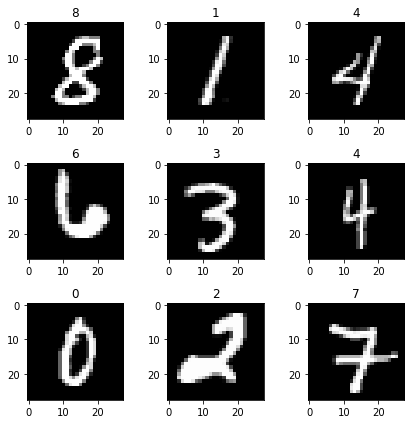

In [8]:
plot_batch(x_batch, y_batch)

### Models

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = nn.Sequential(
            nn.Linear(784, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
        )
        self.latent = nn.Linear(1000, z_dim)
        self.cat = nn.Linear(1000, n_classes)
    
    def forward(self, x):
        x = x.view(-1, 784)
        y = self.base_model(x)
        y_latent = self.latent(y)
        y_cat = self.cat(y)
        return y_latent, y_cat

In [10]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim + n_classes, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 784),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        y = self.model(x)
        y = y.view(-1, 1, 28, 28)
        return y

In [11]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        y = self.model(x)
        return y
        

### Training

In [12]:
def gen_z_gauss(i_size):
    return (torch.randn(i_size, z_dim) * 5).to(device)

In [13]:
def gen_z_cat(i_size, targets):
    one_hot = torch.zeros((i_size, n_classes), device=device)
    return one_hot.scatter(1, targets.view(-1, 1), 1)


CPU times: user 3min 6s, sys: 14.2 s, total: 3min 20s
Wall time: 3min 23s


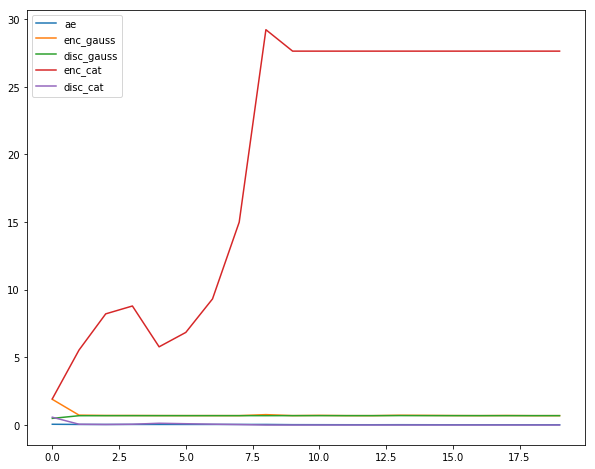

In [23]:
%%time
n_epochs = 20
lr = 1e-3


enc = Encoder().to(device)
dec = Decoder().to(device)
disc_gauss = Discriminator(z_dim).to(device)
disc_cat = Discriminator(n_classes).to(device)

ae_optimizer = optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr = lr)
ae_criterion = nn.MSELoss()

disc_gauss_optimizer = optim.Adam(disc_gauss.parameters(), lr = lr)
enc_gauss_optimizer = optim.Adam(enc.parameters(), lr = lr)

disc_cat_optimizer = optim.Adam(disc_cat.parameters(), lr = lr)
enc_cat_optimizer = optim.Adam(enc.parameters(), lr = lr)

disc_criterion = nn.BCELoss()
enc_criterion = nn.BCELoss()


ae_loss_hist = []
disc_gauss_loss_hist = []
disc_cat_loss_hist = []
enc_gauss_loss_hist = []
enc_cat_loss_hist = []

with tnrange(n_epochs) as t:
    for e in t:
        t.set_description(f'Epoch {e+1}/{n_epochs}')
        
        ae_epoch_loss = 0.0
        disc_gauss_epoch_loss = 0.0
        enc_gauss_epoch_loss = 0.0
        disc_cat_epoch_loss = 0.0
        enc_cat_epoch_loss = 0.0
        
        for inputs, targets in dataloader_train:
            i_size = inputs.size(0)
            
            inputs, targets = inputs.to(device), targets.to(device)
            
            ########################
            # Reconstruction phase #
            ########################
            ae_optimizer.zero_grad()
            z_enc, c_enc = enc(inputs)
            dec_input = torch.cat((z_enc, c_enc), dim=1)
            ae_outputus = dec(dec_input)
            
            ae_loss = ae_criterion(ae_outputus, inputs)
            ae_loss.backward()
            ae_optimizer.step()
            
            ae_epoch_loss += ae_loss.item() * i_size
            
            ########################
            # Regularization phase #
            ########################
            disc_targets = torch.cat((torch.ones(i_size, 1), torch.zeros(i_size, 1)), dim=0).to(device)
            enc_targets = torch.ones(i_size, 1).to(device)
            
            ## Discriminator - gauss
            z_fake, _ = enc(inputs)
                        
            z_real = gen_z_gauss(i_size)
            disc_gauss_inputs = torch.cat((z_real, z_fake.detach()), dim=0)
            disc_gauss_targets = disc_targets.detach() # clone without grads
            
            disc_gauss_optimizer.zero_grad()            
            disc_gauss_outputs = disc_gauss(disc_gauss_inputs)
            disc_gauss_loss = disc_criterion(disc_gauss_outputs, disc_gauss_targets)
            disc_gauss_loss.backward()
            disc_gauss_optimizer.step()
            
            disc_gauss_epoch_loss += disc_gauss_loss.item() * disc_gauss_inputs.size(0)
            
            ## Encoder - gauss
            enc_gauss_optimizer.zero_grad()
            enc_gauss_outputs = disc_gauss(z_fake)
            enc_gauss_targets = enc_targets.detach() # clone without grads
            enc_gauss_loss = enc_criterion(enc_gauss_outputs, enc_gauss_targets)
            enc_gauss_loss.backward()
            enc_gauss_optimizer.step()
            
            enc_gauss_epoch_loss += enc_gauss_loss.item() * i_size
            
            ## Discriminator - cat
            _, c_fake = enc(inputs)
            
            c_real = gen_z_cat(i_size, targets)
            disc_cat_inputs = torch.cat((c_real, c_fake.detach()), dim=0)
            disc_cat_targets = disc_targets.detach() # clone without grads
            
            disc_cat_optimizer.zero_grad()
            disc_cat_outputs = disc_cat(disc_cat_inputs)
            disc_cat_loss = disc_criterion(disc_cat_outputs, disc_cat_targets)
            disc_cat_loss.backward()
            disc_cat_optimizer.step()
            
            disc_cat_epoch_loss += disc_cat_loss.item() * disc_cat_inputs.size(0)
            
            ## Encoder - cat
            enc_cat_optimizer.zero_grad()
            enc_cat_outputs = disc_cat(c_fake)
            enc_cat_targets = enc_targets.detach() # clone without grads
            enc_cat_loss = enc_criterion(enc_cat_outputs, enc_cat_targets)
            enc_cat_loss.backward()
            enc_cat_optimizer.step()
            
            enc_cat_epoch_loss += enc_cat_loss.item() * i_size
            
            
        # End of epoch
        ae_epoch_loss /= dataset_train_size
        disc_gauss_epoch_loss /= (dataset_train_size * 2)
        enc_gauss_epoch_loss /= dataset_train_size
        disc_cat_epoch_loss /= (dataset_train_size * 2)
        enc_cat_epoch_loss /= dataset_train_size
        
        t.set_postfix(ae=ae_epoch_loss, 
                      disc_gauss=disc_gauss_epoch_loss, 
                      enc_gauss=enc_gauss_epoch_loss,
                      disc_cat=disc_cat_epoch_loss, 
                      enc_cat=enc_cat_epoch_loss)
        
        ae_loss_hist.append(ae_epoch_loss)
        disc_gauss_loss_hist.append(disc_gauss_epoch_loss)
        enc_gauss_loss_hist.append(enc_gauss_epoch_loss)
        disc_cat_loss_hist.append(disc_cat_epoch_loss)
        enc_cat_loss_hist.append(enc_cat_epoch_loss)


plt.figure(figsize=(14, 12))
plt.subplot(3, 1, 1)
plt.plot(range(n_epochs), ae_loss_hist, label='ae')
plt.title('ae')

plt.subplot(3, 1, 2)
plt.plot(range(n_epochs), enc_gauss_loss_hist, label='enc_gauss')
plt.plot(range(n_epochs), disc_gauss_loss_hist, label='disc_gauss')
plt.legend()
plt.title('gauss')

plt.subplot(3, 1, 3)
plt.plot(range(n_epochs), enc_cat_loss_hist, label='enc_cat')
plt.plot(range(n_epochs), disc_cat_loss_hist, label='disc_cat')
plt.legend()
plt.title('cat');

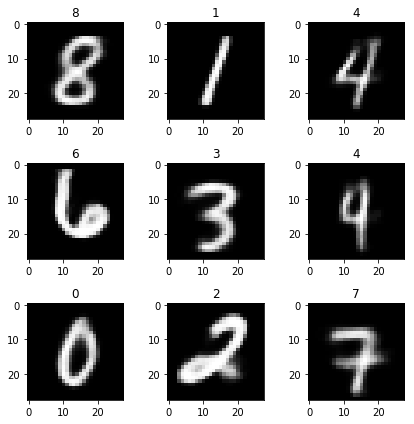

In [24]:
imgs = x_batch.to(device)
z,c = enc(imgs)
with torch.no_grad():
    dec_imgs = dec(torch.cat((z,c), dim=1))
dec_imgs.size()
plot_batch(dec_imgs.detach().cpu(), y_batch)

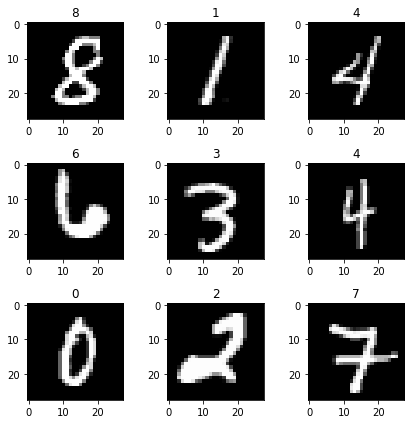

In [25]:
plot_batch(x_batch, y_batch)

In [26]:
z.mean(), z.std()

(tensor(0.5970, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(4.3956, device='cuda:0', grad_fn=<StdBackward0>))

In [27]:
c[:5]

tensor([[-2.4344,  1.1842,  2.6842, -0.1083, -0.3955,  0.2919, -0.1625,  2.6428,
         -1.4787,  3.7158],
        [-0.4308,  1.5748, -0.6624,  0.2491,  0.5096,  2.5232,  0.2776,  0.8603,
         -0.1212,  1.3766],
        [-0.4970, -0.0740,  0.9838, -0.0872,  0.9836, -0.0243,  0.1897, -0.7160,
         -1.9023,  1.0298],
        [-4.3421, -1.8536,  3.8675, -0.3793,  2.3723,  1.5830,  1.9350, -0.6365,
          0.6274, -1.6364],
        [-1.2433,  0.6975,  2.7168,  0.6543, -2.7306,  1.3824, -0.0695,  1.5638,
          3.0662,  2.1375]], device='cuda:0', grad_fn=<SliceBackward>)

In [25]:
c.sum(dim=1)

tensor([  7.8924,  -0.1245,   1.7080,  13.3743,   2.6206,   4.9147,   8.9773,
        -13.1673,   6.9255,   9.4521,   0.5025,  -0.8329,  -1.1997,   5.5821,
          2.6489,   1.9488,   3.9964,   6.0659,  15.4787,   4.6944,   3.0698,
          4.6362,   8.2191,   4.6596,   2.7903,  -6.4385,  -3.2262,   5.4737,
          1.4982,  17.7409,   9.2437,   4.2365,   5.8599,   3.5971,   4.4005,
         -3.4608,   0.5239,   5.1034,  10.8101,   7.6344,  11.0662,   5.6240,
          3.2999,   4.4808,   0.7602,   2.9568,   9.7077,  -8.6934,  -3.7728,
          0.6611,  -0.6217, -16.0474,  -5.8504,   4.2905,   4.1938,  11.7620,
          2.5375,   3.5826,  14.4587,   2.7790,   2.0799,  -9.3261,  -6.4748,
          0.4101,   3.3316,   8.9912,   1.7079,  -2.0614,   0.4139,   4.6693,
          0.3017,   6.1627,   1.6470,   8.9177, -13.9103,  10.2883,   4.9061,
         -1.7707,  -0.1454,  11.2084,   3.4588,  -4.6290,  -7.1760,   2.7070,
         10.0366,   9.1297,  -4.0004,  10.3370,  12.6189,   2.14

In [26]:
with torch.no_grad():
    imgs = dataset_train.data.to(device, dtype=torch.float32)
    z, c = enc(imgs)
    print(z.mean(), z.std())

tensor(157.4600, device='cuda:0') tensor(1417.5452, device='cuda:0')


In [28]:
with torch.no_grad():
    yh = disc_gauss(gen_z_gauss(100))
yh.mean()

tensor(0.4682, device='cuda:0')

In [29]:
with torch.no_grad():
    yh = disc_gauss(z)
yh.mean()

tensor(0.7479, device='cuda:0')